In [1]:
from sklearn import cross_validation,metrics
from sklearn.cross_validation import train_test_split
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numba import jit
import sys
import cPickle as pickle
sys.path.append('/home/oleksandr/FaceRocognition')
from Util import smart_dummy, ensemble_classifier, gini, ROC, plot_feature_importance, print_res_table
sys.path.append('/home/oleksandr/xgboost/xgboost/python-package/')
from copy import deepcopy
from Util import smart_dummy, ensemble_classifier, gini, ROC, plot_feature_importance, print_res_table
import xgboost as xgb
from copy import deepcopy
from Util import smart_dummy, ensemble_classifier, gini, ROC, plot_feature_importance, print_res_table
import xgboost as xgb
from scipy.special import logit,expit
%matplotlib inline

/home/oleksandr/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#%%time
chunksize = 40000
#df_gen  = pd.read_csv('/home/oleksandr/FaceDetection/faces_features_300k_26_10_16_vggnet.csv', chunksize=chunksize,sep = ";",dtype=np.uint8,header=None)
#lbl_gen = pd.read_csv('/home/oleksandr/FaceDetection/faces_300k_labels_26_10_2016.csv',chunksize=chunksize,sep = ";", header=None)

df_gen  = pd.read_csv('/home/oleksandr/FaceDetection/faces_features_cuted_04_11_16_vggnet.csv', chunksize=chunksize,sep = ";",dtype=np.float16,header=None)
lbl_gen = pd.read_csv('/home/oleksandr/FaceDetection/faces_300k_cuted_labels_04_11_2016.csv',chunksize=chunksize,sep = ";", header=None)
df=df_gen.next()
lbl=lbl_gen.next()
print len(lbl[0].value_counts()),'клиентов,', len(lbl[1].value_counts()), 'фото'

12123 клиентов, 40000 фото


#%%time
chunksize = 10000
df_gen  = pd.read_csv('/home/oleksandr/FaceDetection/faces_features_300k_26_10_16_vggnet.csv', chunksize=chunksize,sep = ";",dtype=np.float16,header=None)
lbl_gen = pd.read_csv('/home/oleksandr/FaceDetection/faces_300k_labels_26_10_2016.csv',chunksize=chunksize,sep = ";", header=None)

#df=df_gen.next().astype(np.uint8)
lbl=lbl_gen.next()
#print len(lbl[0].value_counts()),'клиентов,', len(lbl[1].value_counts()), 'фото'

#### делим по-клиентно на train и test

In [4]:
cust_id_train,cust_id_test = train_test_split(lbl.groupby(0).first().index.values,test_size=0.1)
lbl_train = lbl[lbl[0].isin(cust_id_train)]
df_train  = df [lbl[0].isin(cust_id_train)]
lbl_test = lbl[lbl[0].isin(cust_id_test)]
df_test  = df[lbl[0].isin(cust_id_test)]
df_train.shape,lbl_test.shape

((36013, 402), (3987, 2))

In [5]:
mask=np.array([True]*df_train.shape[1])
len(mask)

402

#### Формируем пары

In [6]:
def make_set(df,lbl,dup=True):
    size=len(df)/2*2 # четное количество
    x1,x2,cust1,cust2 = train_test_split(df.as_matrix()[:size][:,mask],
                        lbl.values[:size,0], test_size=0.5)
    
    # вначале соединяем элементы 1 к 1
    X = np.hstack((x1,x2))
    Y = (cust1 == cust2)
     
    # добавляем в обратном порядке со сдвигом на 1 
    if dup:
        X = np.vstack((X,np.hstack((x2[1:],x1[:-1]))))
        Y = np.append(Y, cust2[1:] == cust1[:-1])
         
    # формируем совпадающие пары
    X = list(X)
    for row1,cust1_id in enumerate(cust1):
        ind=np.where(cust2 == cust1_id)[0]
        for row2 in ind:
            X.append(np.hstack((x1[row1],x2[row2])))
            Y = np.append(Y,True)
            
            if not dup: break
    return np.array(X),Y

In [7]:
x_test,y_test    = make_set(df_test,lbl_test,False)
print x_train.shape,x_test.shape,y_test.shape

NameError: name 'x_train' is not defined

In [9]:
def train_step(clf,param,n_estimator,x_train,y_train,x_test,y_test,learning_rates=None,early_stopping_rounds=10):    
    gini0 = gini(x_test, y_test,clf)
    print param,gini(x_train, y_train,clf),'/',gini0
    bst0 = clf._Booster.copy()
    train = xgb.DMatrix(x_train, y_train)
    test  = xgb.DMatrix(x_test,  y_test)
    param['eval_metric']='auc'
    param['objective'] ='binary:logistic'
    clf._Booster = xgb.train(param, train, xgb_model=clf._Booster,
                             evals=[(train,'train'),(test,'test')],
                             early_stopping_rounds=early_stopping_rounds,verbose_eval=10,
                             num_boost_round=n_estimator,learning_rates=learning_rates)
    gini1 = gini(x_test, y_test,clf)
    print 'after:', gini(x_train, y_train,clf),'/', gini1,
    print 'acc train:',metrics.accuracy_score(y_test, clf.predict(x_test))
    
    if gini1 <= gini0:
        print "Rollback !"
        clf._Booster = bst0

In [5]:
ens = ensemble_classifier()

In [5]:
class magrin_clf():
    def __init__(self,first_clf, trns_f=None):
        'Последовательный XGB classifier'
        '   first_clf - базовый классификатор'
        '   trns_f - (при небходимости) функция, преобразовывающая значение входной матрицы x для first_clf)'
        self.first_clf = first_clf
        self.boosters,self.weights = [],[]
        self.trns_f=trns_f
    
    def train(self,param,n_estimator,x_train,y_train,x_test,y_test,
              early_stopping_rounds=10,verbose_eval=10,learning_rates=None):
        train = xgb.DMatrix(x_train,y_train)
        test  = xgb.DMatrix(x_test,y_test)
        ptrain= self.first_clf._Booster.predict(train if self.trns_f is None else 
                                                xgb.DMatrix(self.trns_f(x_train), y_train), output_margin=True)
        ptest = self.first_clf._Booster.predict(test  if self.trns_f is None else
                                                xgb.DMatrix(self.trns_f(x_test),  y_test),  output_margin=True)

        train.set_base_margin(ptrain)
        test.set_base_margin(ptest) 
        evals=[(train,'train'),(test,'test')]
        param['objective'] ='binary:logistic'
        
        bst = xgb.train(param, train, 
                             evals=evals,
                             early_stopping_rounds=early_stopping_rounds,
                             verbose_eval=verbose_eval,
                             num_boost_round=n_estimator,learning_rates=learning_rates)    
        return bst
    
    def add(self,bst,weight=1):
        self.boosters.append(deepcopy(bst))
        self.weights.append(weight)
        
    def predict_proba(self, x):
        D = xgb.DMatrix(x)
        p = self.first_clf._Booster.predict(D if self.trns_f is None else 
                                            xgb.DMatrix(self.trns_f(x)),output_margin=True)
        D.set_base_margin(p)
        
        proba = expit(  \
                [logit(bst.predict(D)) * w for bst,w in  zip(self.boosters, self.weights)] \
                     ).sum(axis=0)/sum(self.weights)
        return np.hstack((1-proba[:,np.newaxis],proba[:,np.newaxis]))
    
    def predict(self,x):
        return self.predict_proba(x)[:,1] > 0.5    

In [15]:
ens_m = magrin_clf(ens.clfs[0])

In [12]:
#x_train,y_train  = make_set(df_train,lbl_train,False)

bst = ens_m.train({'eta':0.07,'max_depth':7,'eval_metric':'auc','subsample':0.9,'colsample_bylevel':0.9}, 2, 
                  x_train,y_train,x_test,y_test)
    
ens_m.add(bst)
print gini(x_test, y_test,ens_m)

Will train until test error hasn't decreased in 10 rounds.
[0]	train-auc:0.986140	test-auc:0.983211
[1]	train-auc:0.986239	test-auc:0.983224
96.43


In [13]:
# Посмотрим содержимое ансамбля
def print_res(x,y,clf):
    print "Gini= {:.4} Accuracy= {:.4}".format(gini(x, y,clf),metrics.accuracy_score(y, clf.predict(x))),       

x_test1,y_test1  = make_set(df_test,lbl_test,False)
ens.fit(x_test1,y_test1)

for i,c in enumerate((ens.clfs+[ens])):
    print str(i)+':  ' if i < len(ens.clfs) else 'Ens:',
    print_res(x_test,y_test,c)
    print_res(x_test1,y_test1,c)
    print

NameError: name 'ens' is not defined

In [316]:
ens.weights=[1,1,1]

In [325]:
# Сохранение текущих результатов
with open('Faces_vgg.dump','wb') as output:
    pickle.dump((df_train,df_test,lbl_train,lbl_test,x_train,y_train,x_test,y_test,clf,ens,ens_m,mask), output, 2)

In [6]:
# Считывание текущих результатов
with open('Faces_vgg.dump','rb') as input:  
               (df_train,df_test,lbl_train,lbl_test,x_train,y_train,x_test,y_test,clf,ens,ens_m,mask) = pickle.load(input)

In [797]:
# выгрузка для сравнения
pr=ens.predict_proba(x_test)[:,1]
order=np.argsort(pr)
df_res=pd.DataFrame({"ref1":ref_test[order,0],"ref2":ref_test[order,1],"Y":y_test[order],
                     "Proba":pr[order]})
df_res.to_csv('lbl_res.csv')

In [7]:
lbl_res2=pd.read_csv('lbl_res_out2.csv',header=None)
lbl_res2.head()

,0,1,2,3,4,5
0,1,0.000062,False,615878630,711547647.0,0.096
1,2,0.000070,False,516897333,374850170.0,0.000
2,3,0.000093,False,505369281,711576288.0,0.006
3,4,0.000094,False,698634720,710564682.0,0.002
4,5,0.000095,False,514496061,595892010.0,0.050


In [36]:
metrics.accuracy_score(lbl_res.Proba[:len(lbl_res2)] > 0.5,lbl_res.Y[:len(lbl_res2)])
metrics.accuracy_score(lbl_res.Proba[:len(lbl_res2)] > 0.5,lbl_res.Y[:len(lbl_res2)])

0.92362079267078268

### Выбор фич - SelectFromModel

In [136]:
from sklearn.feature_selection import SelectFromModel
new_mask = SelectFromModel(ens.clfs[0],prefit=True,threshold='0.7*mean').get_support()
print len(new_mask),sum(new_mask),
for clf in ens.clfs:
    new_mask = new_mask | SelectFromModel(clf,prefit=True,threshold='0.7*mean').get_support()

print sum(new_mask)

898 729 729


In [137]:
short_mask=new_mask[:len(new_mask)/2] | new_mask[len(new_mask)/2:]
print sum(short_mask),sum(short_mask*2),len(mask),len(short_mask)

402 804 4096 449


In [14]:
mask=short_mask

In [61]:
def join_mask(mask0,mask1):
    mask=np.empty(len(mask0))
    j=0
    m1=list(mask1)+[False]
    for i,byte in enumerate(mask0):
        mask[i] = byte & m1[j]
        j += byte 
    return np.array([bool(byte) for byte in mask])

In [138]:
old_mask=mask
mask402=join_mask(mask,short_mask)
len(mask402),sum(mask402),len(old_mask),sum(old_mask)

(4096, 402, 4096, 449)

In [139]:
mask=mask402

### distance

In [10]:
from scipy.spatial.distance import braycurtis
def dist(x):
    dim=x.shape[1]/2
    return np.array([ [ braycurtis(x[i,:dim],x[i,dim:])]  for i in range(len(x))])  

In [11]:
def make_set_plus(df,lbl,dup=False):
    x,y = make_set(df,lbl,dup)
    x = np.hstack((x,dist(x)))
    return x,y

In [12]:
x_test1,y_test = make_set_plus(df_test,lbl_test,False)
ens2=ensemble_classifier()

In [13]:
x_train1,y_train  = make_set_plus(df_train,lbl_train,True)

In [10]:
x_test1.shape

(30564, 805)

In [14]:
for it in range(6):
    x_train1,y_train  = make_set_plus(df_train,lbl_train,False)
    
    clf=xgb.XGBClassifier(n_estimators=1)
    clf.fit(x_train1,y_train)

    train_step(clf,{'max_depth':6+it%3},
               300, x_train1,y_train,x_test1,y_test,early_stopping_rounds=20,
               learning_rates=[0.3]*100 + [0.2]*100 + [0.1]*100)

    ens2.add(clf)

{'max_depth': 6} 85.5 / 82.06
[0]	train-auc:0.951316	test-auc:0.929571
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 20 rounds.
[10]	train-auc:0.975069	test-auc:0.947894
[20]	train-auc:0.986156	test-auc:0.950727
[30]	train-auc:0.992509	test-auc:0.952623
[40]	train-auc:0.996105	test-auc:0.953331
[50]	train-auc:0.998261	test-auc:0.955137
[60]	train-auc:0.99919	test-auc:0.954535
[70]	train-auc:0.999726	test-auc:0.955745
[80]	train-auc:0.999897	test-auc:0.95596
[90]	train-auc:0.999968	test-auc:0.956296
[100]	train-auc:0.999995	test-auc:0.957148
[110]	train-auc:0.999999	test-auc:0.957408
[120]	train-auc:1	test-auc:0.957367
[130]	train-auc:1	test-auc:0.957662
[140]	train-auc:1	test-auc:0.95803
[150]	train-auc:1	test-auc:0.958181
[160]	train-auc:1	test-auc:0.958228
Stopping. Best iteration:
[149]	train-auc:1	test-auc:0.958247

after: 100.0 / 91.63 acc train: 0.888479001135
{'max_depth': 7} 85.58 / 82.24
[0]	tr

In [14]:
# Посмотрим содержимое ансамбля
def print_res(x,y,clf):
    print "Gini= {:.4} Accuracy= {:.4}".format(gini(x, y,clf),metrics.accuracy_score(y, clf.predict(x))),

In [15]:
metrics.accuracy_score(y_test, ens2.predict(x_test1))

0.93458201349676351

In [14]:
# Посмотрим содержимое ансамбля
# подбор весов
def acc(y,pred):
    return metrics.accuracy_score(y,pred>0.5)
x_test_1,y_test_1  = make_set_plus(df_test,lbl_test,True)
ens2.fit(x_test_1,y_test_1,tol=0.0001,val_func= acc)
print " Веса:", ens2.weights

#x_test_1,y_test_1  = make_set_plus(df_test,lbl_test,True)
for i,c in enumerate((ens2.clfs+[ens2])):
    print str(i)+':  ' if i < len(ens2.clfs) else 'Ens:',
    print_res(x_test1,y_test,c)
    print_res(x_test_1,y_test_1,c)
    print

     fun: -0.9372801752279859
 message: 'Optimization terminated successfully.'
    nfev: 1357
     nit: 14
 success: True
       x: array([ 0.34376913,  0.67913554,  0.15728976,  0.64882213,  0.84644019,
        0.96542839])
 Веса: [0.35607936998232348, 0.70345511911595227, 0.16292224478538123, 0.6720561989544962, 0.87675087658772566, 1.0]
0:   Gini= 96.28 Accuracy= 0.9361 Gini= 96.43 Accuracy= 0.9317
1:   Gini= 96.3 Accuracy= 0.9362 Gini= 96.34 Accuracy= 0.9326
2:   Gini= 96.49 Accuracy= 0.9354 Gini= 96.52 Accuracy= 0.9324
3:   Gini= 96.37 Accuracy= 0.9351 Gini= 96.46 Accuracy= 0.9324
4:   Gini= 96.38 Accuracy= 0.9359 Gini= 96.39 Accuracy= 0.9337
5:   Gini= 96.45 Accuracy= 0.935 Gini= 96.42 Accuracy= 0.9327
Ens: Gini= 97.0 Accuracy= 0.9403 Gini= 97.02 Accuracy= 0.9373


In [15]:
# Сохранение текущих результатов
with open('Faces_vgg_ens2_04_acc_09373_11_2016.dump','wb') as output:
    pickle.dump((df_train,df_test,lbl_train,lbl_test,x_train1,y_train,x_test1,y_test,clf,ens2,mask), output, 2)

In [16]:
%pwd

u'/home/oleksandr/FaceRocognition'

In [28]:
# Посмотрим содержимое ансамбля
# подбор весов
def acc(y,pred):
    return metrics.accuracy_score(y,pred>0.5)
x_test_1,y_test_1  = make_set_plus(df_test,lbl_test,True)
ens2.fit(x_test_1,y_test_1,tol=0.0001,val_func= acc)
print " Веса:", ens2.weights

#x_test_1,y_test_1  = make_set_plus(df_test,lbl_test,True)
for i,c in enumerate((ens2.clfs+[ens2])):
    print str(i)+':  ' if i < len(ens2.clfs) else 'Ens:',
    print_res(x_test1,y_test,c)
    print_res(x_test_1,y_test_1,c)
    print

     fun: -0.93715275272386178
 message: 'Optimization terminated successfully.'
    nfev: 2437
     nit: 26
 success: True
       x: array([ 0.20639527,  0.83017289,  0.5882745 ,  0.3106219 ,  0.87580538,
        0.39107753])
 Веса: [0.23566339217059534, 0.94789654625355446, 0.67169547093264526, 0.35467001172781576, 1.0, 0.44653474578604191]
0:   Gini= 96.3 Accuracy= 0.9356 Gini= 96.21 Accuracy= 0.9334
1:   Gini= 96.26 Accuracy= 0.9357 Gini= 96.34 Accuracy= 0.9325
2:   Gini= 96.22 Accuracy= 0.9362 Gini= 96.22 Accuracy= 0.9331
3:   Gini= 96.19 Accuracy= 0.9352 Gini= 96.16 Accuracy= 0.9324
4:   Gini= 96.23 Accuracy= 0.9371 Gini= 96.23 Accuracy= 0.9335
5:   Gini= 96.27 Accuracy= 0.9381 Gini= 96.25 Accuracy= 0.9328
Ens: Gini= 96.65 Accuracy= 0.9394 Gini= 96.64 Accuracy= 0.9372


In [25]:
for i in [3,5]: ens2.weights[i]=0

In [102]:
import Util
reload(Util)
ensemble_classifier=Util.ensemble_classifier
ens_new=ensemble_classifier()
ens_new.clfs=ens2.clfs
ens_new.weights=ens2.weights
ens2=ens_new
#ens_new.fit(x_train1,y_train)
#ens_new.weights

#### Distance + Margin

In [14]:
x_train,y_train  = make_set(df_test,lbl_test,False)

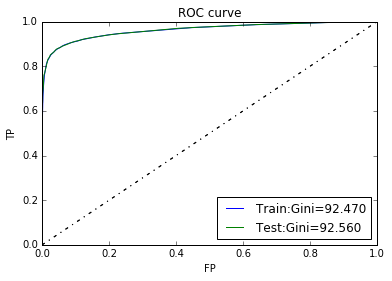

In [96]:
dist_test = dist(x_test)
dist_train= dist(x_train)
clf  = xgb.XGBClassifier(n_estimators=5,max_depth=3,learning_rate=1)
clf.fit(dist_train,y_train)
ROC(dist_train, y_train,clf,"Train")
ROC(dist_test,  y_test, clf,"Test")

In [88]:
#ens_m=magrin_clf(clf, dist)
x_train,y_train  = make_set(df_train,lbl_train,False)
dist_train= dist(x_train)
dist_test= dist(x_test)

bst = ens_m.train({'eta':0.25,'max_depth':5,'eval_metric':'auc','subsample':0.8,'colsample_bylevel':0.8}, 100, 
                  x_train,y_train,x_test,y_test, verbose_eval=10)
    
ens_m.add(bst)
print_res(x_test,y_test,ens_m)

Will train until test error hasn't decreased in 10 rounds.
[0]	train-auc:0.966527	test-auc:0.966439
[10]	train-auc:0.976870	test-auc:0.972965
[20]	train-auc:0.980586	test-auc:0.974190
[30]	train-auc:0.983176	test-auc:0.974670
[40]	train-auc:0.984967	test-auc:0.974979
[50]	train-auc:0.986689	test-auc:0.975522
[60]	train-auc:0.988096	test-auc:0.976177
[70]	train-auc:0.989357	test-auc:0.976425
[80]	train-auc:0.990252	test-auc:0.976640
[90]	train-auc:0.991062	test-auc:0.976853
[99]	train-auc:0.991909	test-auc:0.976868
Gini= 95.87 Accuracy= 0.9317


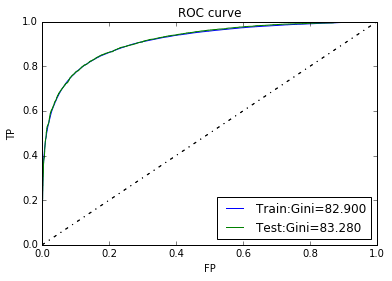

In [73]:
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression()
clf1.fit(dist_train,y_train)
ROC(dist_train, y_train,clf1,"Train")
ROC(dist_test,  y_test, clf1,"Test")

In [19]:
print_res_table(dist_test[:,np.newaxis],y_test,clf1)

Prob  Count  Count Count  Bad    Bad      Bad
               Bad  Good  Rate,% Rate,cum Rate,cm0
 0.24   167      6   161  3.593  43.742   3.593
 1.73   166     11   155  6.627  48.227   5.105
 3.23   166      9   157  5.422  53.424   5.210
 5.36   166      5   161  3.012  60.275   4.662
10.19   166     13   153  7.831  69.809   5.295
21.74   166     44   122 26.506  82.190   8.826
59.29   166    141    25 84.940  96.090  19.690
91.90   166    165     1 99.398  99.800  29.646
97.98   166    166     0 100.000 100.000  37.458
99.72   166    166     0 100.000 100.000  43.742
Gini =  92.5%


In [110]:
def predict(x,clf,threshold):
    prob = clf.predict_proba(x)
    return prob[:,1]>threshold
print 'Accuracy',metrics.accuracy_score(y_test,predict(dist_test[:,np.newaxis],clf1,0.5))
print metrics.classification_report(y_test,predict(dist_test[:,np.newaxis],clf1,0.5))
print 'Accuracy',metrics.accuracy_score(y_test,predict(x_test,ens,0.5))
print metrics.classification_report(y_test,predict(x_test,ens,0.5))

Accuracy 0.92551286226
             precision    recall  f1-score   support

      False       0.92      0.95      0.93      6827
       True       0.94      0.89      0.91      5457

avg / total       0.93      0.93      0.93     12284

Accuracy 0.942445457506
             precision    recall  f1-score   support

      False       0.93      0.96      0.95      6827
       True       0.95      0.92      0.93      5457

avg / total       0.94      0.94      0.94     12284



In [236]:
def predict(x,clf,threshold):
    prob = clf.predict_proba(x)
    return prob[:,1]>threshold

print metrics.classification_report(y_test,predict(x_test,ens,0.50))

             precision    recall  f1-score   support

      False       0.93      0.94      0.94      6893
       True       0.93      0.91      0.92      5486

avg / total       0.93      0.93      0.93     12379



In [6]:
with open('face402.dump','rb') as input:  mask402,ens2 = pickle.load(input)

In [7]:
mask=mask402

In [9]:
file='mask.dump'
with open(file,'rb') as input:  mask1700 = pickle.load(input)[0]

In [10]:
import cPickle as pickle
with open('face_487.dump','rb') as input:  mask487 = pickle.load(input)[0]
mask4096=join_mask(mask1700,mask487)
print len(mask487),sum(mask487),len(mask4096),sum(mask4096)

855 487 4096 487


In [11]:
with open('face_487.dump','rb') as input:  mask487,ens487 = pickle.load(input)
#with open('face_487.dump','wb') as output: pickle.dump((mask487,mask4096,ens487),output,2)

In [799]:
mask330=mask
len(mask330),sum(mask330)

(855, 330)

In [801]:
mask4096_330=join_mask(mask1700,mask330)
len(mask4096_330),sum(mask4096_330)

(4096, 330)

In [802]:
with open('mask4096_330.dump','wb') as output:
    pickle.dump((mask4096_330), output, 2)

In [13]:
mask=mask487
ens=ens487